In [2]:
import polars as pl
import matplotlib.pyplot as plt

In [70]:
def create_trips_df(xwalk:pl.DataFrame, rts:list, is_scheduled:bool = False):
    """
    Given rts to pids xwalk and a list of rts, create a df for all the trips for the rts
    """
    
    trips = []

    # just look at the rts for schedule
    if is_scheduled:
        iter = rts
        file_DIR = '../cta-stop-etl/out/clean_timetables/rt{rt}_timetable.parquet'
        error = "Do not have timetable for route {rt}. Skipping"
    else: 
        pids = xwalk.filter(pl.col("rt").is_in(rts)).unique("pid")
        rt_pid = pids.rows()
        iter = rt_pid
        
        file_DIR = '../cta-stop-etl/out/trips/trips_{pid}_full.parquet'
        error = "Do not have pattern {pid} for route. Skipping"
        

    for obj in iter:
        if is_scheduled:
            rt = obj
            template_values = {"rt": rt}
            
        else:
            rt, pid = obj
            template_values = {"pid": pid}

        try:
            df_trips = pl.read_parquet(file_DIR.format(**template_values))
        except FileNotFoundError:
            print(error.format(**template_values))
            continue
            
        if not is_scheduled:
            # for now
            df_trips = df_trips.filter(pl.col('typ') == 'S')
            df_trips = df_trips.with_columns(pl.lit(pid).cast(pl.Int64).alias('pid'),
                                            pl.lit(rt).cast(pl.Int64).alias('rt'))
        
        
        trips.append(df_trips)    

    df_trips_all = pl.concat(trips)

    if is_scheduled:
        df_trips_all = df_trips_all.rename({'route_id': 'rt'})
        df_trips_all = df_trips_all.with_columns(
            trip_id = pl.col('schd_trip_id') + pl.col('bus_stop_time').dt.date().cast(pl.String)
            )
    else:
        df_trips_all = df_trips_all.rename({"unique_trip_vehicle_day": "trip_id", 'stpid': 'stop_id'})

    return df_trips_all


def time_to_next_stop(trips_df:pl.DataFrame, is_daytime:bool = True, ):
    
    if is_daytime:
        trips_df = trips_df.filter(pl.col('bus_stop_time').dt.hour().is_between(6, 20))

    trips_df = trips_df.sort(by=['trip_id', 'bus_stop_time'])
    trips_df = trips_df.with_columns(time_to_previous_stop =
        (pl.col("bus_stop_time") -pl.col("bus_stop_time").shift(1))
        .over(pl.col("trip_id").rle_id()))
    
    trips_df = trips_df.with_columns(pl.col("time_to_previous_stop").fill_null(strategy="zero"))

    trips_df = trips_df.with_columns(cum_trip_time =
        pl.cum_sum("time_to_previous_stop")
        .over(pl.col("trip_id").rle_id()))
    
    trips_df = trips_df.with_columns(stop_sequence = (
        pl.col('bus_stop_time').rank("ordinal")
        .over(pl.col('trip_id').rle_id())))


    trips_df = trips_df.with_columns((pl.col('bus_stop_time').dt.hour()).alias('hour'), 
                      (pl.col('bus_stop_time').dt.month()).alias('month'),
                      (pl.col('bus_stop_time').dt.year()).alias('year'),
                        (pl.col('bus_stop_time').dt.day()).alias('day'))

    return trips_df


def group_metrics(trips_df:pl.DataFrame, group_type:str, metric:str):

    if group_type == 'bus_stop':
        group_type = ['pid', 'stop_id', 'stop_sequence']
    else:
        group_type = [group_type]

    trips_df = trips_df.group_by(['rt',*group_type]).agg(
            median = pl.median(metric),
            mean = pl.mean(metric),
            max = pl.max(metric),
            min = pl.min(metric),
            std = pl.std(metric),
            q25 = pl.col(metric).quantile(0.25),
            q75 = pl.col(metric).quantile(0.75),
    )
    
    return trips_df.sort(['rt',*group_type])


def find_metric(is_schedule:bool, metric:str, rts:list, group_type:str = 'stop_id'):
    """
    Calculate a metric for the given rts for other real bus locations of from the schedule.
    """

    rt_to_pid = pl.read_parquet('rt_to_pid.parquet')

    trips_df = create_trips_df(rt_to_pid, rts = rts, is_scheduled=is_schedule)

    if metric == 'time_to_next_stop':
        return time_to_next_stop(trips_df,group_type = group_type)

def chart_schedule_vs_real(schedule, real, groupby):

    fig, ax = plt.subplots()
    ax.plot(schedule[groupby], schedule['median'], label = 'Schedule')
    ax.plot(real[groupby], real['median'], label = 'Real')

    ax.legend()
    plt.show()

    


In [97]:
rt_to_pid = pl.read_parquet('rt_to_pid.parquet')

#median for schedule
trips_df = create_trips_df(rt_to_pid, rts = ['172'], is_scheduled=True)
test = time_to_next_stop(trips_df)
schedule_metrics = group_metrics(test, 'bus_stop', 'cum_trip_time').sort(['pid','stop_sequence'])

test_schedule = schedule_metrics.filter(pl.col('pid') == '4103')

#median for real
trips_df = create_trips_df(rt_to_pid, rts = ['172'], is_scheduled=False)
bus_trips = time_to_next_stop(trips_df)
bus_metrics = group_metrics(bus_trips, 'bus_stop', 'cum_trip_time').sort(['pid','stop_sequence'])

test_bus = bus_metrics.filter(pl.col('pid') == 14103)

#sample of 100 bus trips
sample_trips = bus_trips.filter(pl.col('pid') == 14103).select(pl.col('trip_id')).sample(100)
bus_trips_sample = bus_trips.filter(pl.col('trip_id').is_in(sample_trips))

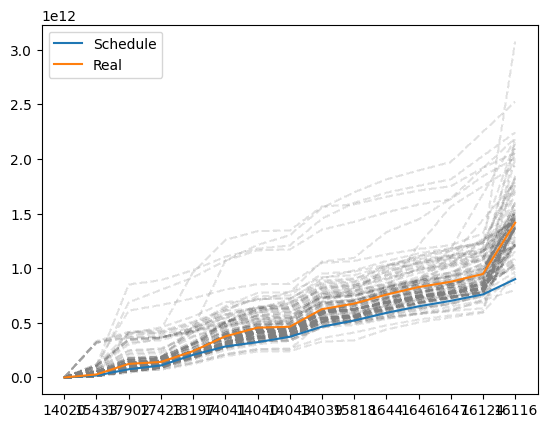

In [152]:

fig, ax = plt.subplots()

#for trip in range(bus_trips_sample.select('trip_id').unique()):
    #subset = bus_trips_sample.slice(i,1)


for row in bus_trips_sample.iter_rows(named=True):
    subset = bus_trips_sample.filter(pl.col('trip_id') == row['trip_id'])
    ax.plot(subset['stop_id'], subset['cum_trip_time'], color = 'grey', alpha=0.01, linestyle='dashed')

ax.plot(test_schedule['stop_id'], test_schedule['median'], label = 'Schedule')
ax.plot(test_bus['stop_id'], test_bus['median'], label = 'Real')

ax.legend()
plt.show()


In [49]:
# 

groupby = 'hour'

schedule = find_metric(is_schedule = True, metric = 'time_to_next_stop', rts = ['28'], group_type = groupby)
schedule = schedule.select([groupby,'median'])
Buses = find_metric(is_schedule = False, metric = 'time_to_next_stop', rts = ['28'], group_type = groupby)
Buses = Buses.select([groupby,'median'])


join = schedule.join(Buses, on=groupby, how="inner")
with pl.Config(tbl_rows=24):
    print(join.rename({"median": "schedule_median", "median_right": "real_median"}))

Do not have pattern 2268 for route. Skipping
Do not have pattern 2271 for route. Skipping
shape: (15, 3)
┌──────┬─────────────────┬─────────────────┐
│ hour ┆ schedule_median ┆ real_median     │
│ ---  ┆ ---             ┆ ---             │
│ i8   ┆ duration[ns]    ┆ duration[ns]    │
╞══════╪═════════════════╪═════════════════╡
│ 6    ┆ 32s             ┆ 33s 229568626ns │
│ 7    ┆ 39s             ┆ 37s 193076745ns │
│ 8    ┆ 39s             ┆ 39s 533856427ns │
│ 9    ┆ 37s             ┆ 37s 42311089ns  │
│ 10   ┆ 35s             ┆ 37s 757334782ns │
│ 11   ┆ 36s             ┆ 38s 273873367ns │
│ 12   ┆ 36s             ┆ 39s 142213538ns │
│ 13   ┆ 37s             ┆ 39s 353164420ns │
│ 14   ┆ 37s             ┆ 40s 531167366ns │
│ 15   ┆ 40s             ┆ 42s 135829331ns │
│ 16   ┆ 43s             ┆ 44s 520960365ns │
│ 17   ┆ 42s             ┆ 42s 477742328ns │
│ 18   ┆ 39s             ┆ 38s 393155414ns │
│ 19   ┆ 36s             ┆ 35s 541683677ns │
│ 20   ┆ 34s             ┆ 33s 928769984

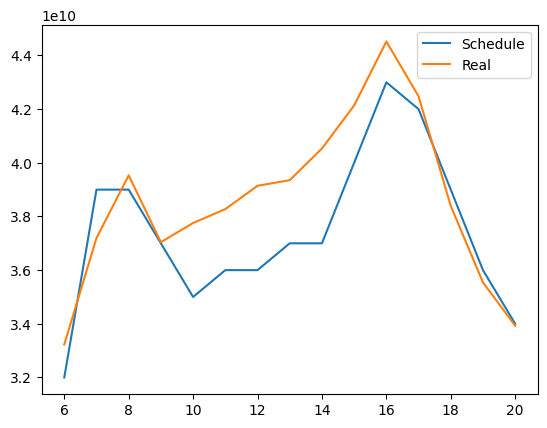

In [51]:
chart_schedule_vs_real(schedule, Buses, groupby)